# Finding Fear-mongering Tweets with Machine Learning


## Overview

Our challenge is to find tweets by US congressional candidates that are **examples of fear-mongering**.

Recognizing fear mongering seems like it might be a uniquely human skill. But we can make a machine-learning mmodel that does it pretty well.

### First, the language model

We'll get into the details below, but here's our two-step process for this project:

First, we need a model trained to recognize the patterns of English. For that, we'd need some huge dataset of English-language text. Fortunately, someone has already done that for us! We'll be using a model trained on thousands of long Wikipedia articles. It's called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset).

We'll then use _transfer learning_ (like we did in for the helicopter maps) to further train wikitext-103 on our particular corpus: a few thousand candidate tweets. So we benefit from it's training on both English-language articles _and_ the tweets.

That will give us a **language model** that's good at detecting patterns in candidate tweets.


### Second, the classification model

Next we need a model that will sort -- aka _classify_ -- tweets into fear-mongering and not. This will combine the patern-recognition embedded in the language model and examples of both kinds of tweets to make a predition on which class _new_ tweets belong to. This is our **classification model**.


## The Plan

Here's what we're going to do:

- Grab files with a bunch of tweets
- Make a **language model** from a model pretrained on Wikipedia _plus_ all the tweets as we have
- Make a **classification model** to predict whether a given tweet is checkable or not, using tweets that were hand-labeled by students in the Newmark J-School's online investigations class.
- Use that classification model to predict the fear-mongering status of unseen tweets.

## Credits

This notebook was based on one originally created by Jeremy Howard and the other folks at [fast.ai](https://fast.ai) as part of [this fantastic class](https://course.fast.ai/). Specifically, it comes from Lesson 4. You can [see the lession video](https://course.fast.ai/videos/?lesson=4) and [the original class notebook](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb). 

The idea for the project came from students in the Newmark J-School's online investigations class. Tweets were coded by Ben Abrams, Holly Deaton, Christine Derosa, Amanda Glodowski, Elias Guerra, May Olvera, Luca Powell, Sam Sharpe, and Jacob Wasserman.

-- John Keefe, [Quartz](https://qz.com), May 2020

## Setup

### For those using Google Colaboratory ...

Be aware that Google Colab instances are ephemeral -- they vanish *Poof* when you close them, or after a period of sitting idle (currently 90 minutes), or if you use one for more than 12 hours.

If you're using Google Colaboratory, be sure to set your runtime to "GPU" which speeds up your notebook for machine learning:

![change runtime](https://qz-aistudio-public.s3.amazonaws.com/workshops/notebook_images/change_runtime_2.jpg)
![pick gpu](https://qz-aistudio-public.s3.amazonaws.com/workshops/notebook_images/pick_gpu_2.jpg)

Then run this cell:

In [1]:
## ALL GOOGLE COLAB USERS RUN THIS CELL

## This runs a script that installs fast.ai
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


### For those _not_ using Google Colaboratory ...

This section is just for people who decide to use one of the notebooks on a system other than Google Colaboartory. 

Those people should run the cell below.

In [ ]:
## NON-COLABORATORY USERS SHOULD RUN THIS CELL
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Everybody do this ...

Everyone needs to run the next cell, which initializes the Python libraries we'll use in this notebook.

In [2]:
## AND *EVERYBODY* SHOULD RUN THIS CELL
import warnings
warnings.filterwarnings('ignore')
from fastai.text import *
import fastai
print(f'fastai: {fastai.__version__}')
print(f'cuda: {torch.cuda.is_available()}')

fastai: 1.0.61
cuda: True


## The Data

We're going to be using two sets of tweets for this project:

- A CSV (comma-separated values file) containing a corpus of tweets
- A CSV of tweets that have been hand-coded as "fear-mongering" (true or false)


In [3]:
# Run this cell to download the data we'll use for this exercise
!wget -N https://s3.amazonaws.com/media.johnkeefe.net/newmark-investigations/corpus.csv --quiet
!wget -N https://s3.amazonaws.com/media.johnkeefe.net/newmark-investigations/scored.csv --quiet
print('Done!')

Done!


Let's take a look.

In [4]:
%ls

corpus.csv  data@  models@  scored.csv


### Take a peek at the tweet data

The Newmark J-School students coded the tweets as "fear-mongering" specifically about the Covid-19 pandemic, and about other topics. We then created an "either" column for fear mongering of either type.

In [5]:
# Here I read the csv into a data frame I called `austin_tweets`
# and take a look at the first few rows
data_path = './'
hand_coded_tweets = pd.read_csv(data_path + 'scored.csv')
hand_coded_tweets.head()

,content,covid_final,other_final,covid,other,either
0,Thank you to all those fighting COVID-19 on th...,0.0,0.0,False,False,False
1,The Arizona Department of Health Services has ...,0.0,0.0,False,False,False
2,The Arizona Department of Health Services has ...,0.0,0.0,False,False,False
3,RT @animalag: FFA and 4-H members are lending ...,0.0,0.0,False,False,False
4,"As of today, I am officially on the ballot for...",0.0,0.0,False,False,False


In [7]:
# read in the corpus, which has one tweet per row,
# and take a look at the first frew rows
corpus_tweets = pd.read_csv(data_path + 'corpus.csv')
corpus_tweets.head()

,content
0,Thank you to all those fighting COVID-19 on th...
1,The Arizona Department of Health Services has ...
2,The Arizona Department of Health Services has ...
3,RT @animalag: FFA and 4-H members are lending ...
4,"As of today, I am officially on the ballot for..."


## Building the language model

First we need a model that 'understands' the rules of English, and ideally also recognizes patterns in our particular corpus. This is the language model. 

We'll start with a language model pretrained on a thousands of Wikipedia articles called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset). That language model has been trained to guess the next word in a sentence based on all the previous words. It has a recurrent structure with a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

For our project, we want to infuse the Wikitext model with our particular dataset – the #txlege tweets. Because the English of candidate tweets isn't the same as the English of Wikipedia, we'll adjust the internal parameters of the model by a little bit. That includes adding words that might be extremely common in the tweets but would be barely present in wikipedia–and therefore might not be part of the vocabulary the model was trained on.

### Using all of our tweets for the language model

We want as many tweets for the language model as possible to learn the patterns of candidate tweets.


In [8]:
# here I concatenate the two tweet sets into one big set
lm_tweets = corpus_tweets

# as a sanity check, let's look at the size of each set, 
# and then the ontatenated set
print('hand coded tweets:', len(hand_coded_tweets) )
print('corpus of tweets:', len(corpus_tweets) )
print('total tweets:', len(lm_tweets) )

hand coded tweets: 3215
corpus of tweets: 4002
total tweets: 4002


We need to make sure there's an entry on every row of the language model tweets, so we check to see if there are any "null" values using this command:

In [11]:
lm_tweets.isnull().sum().sum()

9

Ah, yes, there are a few. That will trip up the model. So let's zap 'em.

In [ ]:
lm_tweets.dropna(inplace=True)

In [15]:
lm_tweets.isnull().sum().sum()

0

In [ ]:
# Saving as csv for easier reading in a moment
lm_tweets.to_csv(data_path + 'lm_tweets.csv', index=False)

Fast.ai uses a concept called a "[data bunch](https://docs.fast.ai/basic_data.html)" to handle machine-learning data, which takes care of a lot of the more fickle machine-learning data preparation.

We have to use a special kind of data bunch for the language model, one that ignores the labels, and will shuffle the texts at each epoch before concatenating them all together (only the training set gets shuffled; we don't shuffle for the validation set). It will also create batches that read the text in order with targets (aka the best guesses) that are the next word in the sentence.


In [19]:
# Loading in data with the TextLMDataBunch factory class, using all the defaults
data_lm = TextLMDataBunch.from_csv(data_path, 'lm_tweets.csv', text_cols='content', label_cols='either')
data_lm.save('data_lm_tweets')

We can then put all of our tweets (now stored in `data_lm`) into a learner object along with the pretrained Wikitext model -- here called `AWD_LTSM`, which is downloaded the first time you'll execute the following line.

In [21]:
my_model = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

One of the most important settings when we actually _train_ our model is the **learning rate**. I'm not going to dive into it here (though I encourage you to explore it), but will use a fast.ai tool to find the best learning rate to start with:

In [24]:
my_model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


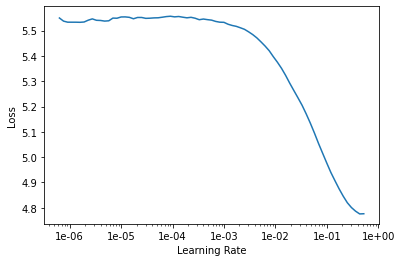

In [25]:
my_model.recorder.plot(skip_end=15)

This gives us a graph of the optimal learning rate ... which is the point where the graph really dives downward (`1e-02`). Again, there's much more on picking and learning rates in the fast.ai course.

Now we can train the Language Model. (Essentailly, we're training it to be good at guessing the *next word* in a sentence, given all of the previous words.)

The variabales we're passing are `1` to just do one cycle of learning, the learning rate of `1e-2`, and some momentum settings we won't get into here -- but these are pretty safe. 

In [26]:
my_model.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.305858,3.604853,0.362029,00:05


In [27]:
my_model.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,3.661641,3.383069,0.377530,00:05


To complete the fine-tuning, we "unfreeze" the original wikitext-103 language model and let our new training efforts work their way into the original neural network.

In [28]:
# This takes a couple of minutes!
my_model.unfreeze()
my_model.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.881653,3.223611,0.397520,00:07
1,2.654814,3.216478,0.401563,00:07


While our accuracy may _seem_ low ... in this case it means the language model correctly guessed the next word in a sentence more than 1/3 of the time. That's pretty good! And we can see that even when it's wrong, it makes some pretty "logical" guesses. 

Let's give it a starting phrase and see how it does:


In [29]:
TEXT = "I want to thank"
N_WORDS = 40
N_SENTENCES = 3

print("\n\n".join(my_model.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I want to thank everyone who attended our Facebook live town hall ! https : / / t.co / ol5bezhln3 xxbos Today 's Endorser of the Day is Tom Lloyd ! 
 
  We are proud of

I want to thank the President for working hard to flatten the curve in # MN01 . We continue to make sure we all have this # COVID19 crisis we can not allow . We should be grateful .

I want to thank everyone who came out to speak about the issues in the district and to answer a answer on # coronavirus . We need to answer a question and answer a solution . Learn more . My questions


Remember, these are not real ... they were _generated_ by the model when it tried to guess each of the next words in the sentence! Generating text like this is not why we made the language model (though you can see where text-generation AI starts from!)

Also note that the model is often crafting the response _in the form of a tweet!_

We now save the model's encoder, which is the mathematical representation of what the language model "understands" about English patterns infused by our tweets.

In [ ]:
my_model.save_encoder('fine_tuned_enc')  

## Building the classifier model

This is the model that will use our langauge model **and** the hand-coded tweets to guess if new tweets are fear-mongering or not.

We'll create a new data bunch that only grabs the hand-coded tweets and keeps track of the labels there (true or false, for fear-mingering). We also pass in the `vocab` -- which is the list of the most useful words from the language model.

In [31]:
data_clas = TextClasDataBunch.from_csv(data_path, 'scored.csv', vocab=data_lm.vocab, text_cols='content', label_cols='either')

data_clas.save('data_clas_tweets')

We can then create a model to classify tweets. You can see that in the next two lines we include the processed, hand-coded tweets (`data_clas`), the original Wikitext model (`AWD_LSTM`), and the knowledge we saved after infusing the language model with tweets (`fine_tuned_enc`).

In [ ]:
my_model = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
my_model.load_encoder('fine_tuned_enc');

With neural networks, there are lots of tweaks you can adjust — known as "hyperparameters" — such as learning rate and momentum. The fast.ai defaults are pretty great, and the tools it has for finding the learning rate are super useful. I'm going to skip those details here for now. There's more to learn at [qz.ai](https://qz.ai) or at the [this great fast.ai course](https://course.fast.ai/).

In [33]:
my_model.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))

my_model.freeze_to(-2)
my_model.fit_one_cycle(2, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

my_model.freeze_to(-3)
my_model.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.562637,0.328664,0.906832,00:03
1,0.374253,0.228666,0.908385,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.284790,0.229790,0.917702,00:03
1,0.246976,0.216539,0.916149,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.214918,0.239480,0.914596,00:05
1,0.185822,0.230715,0.914596,00:05


Let's give it an example ....

In [34]:
example = "Once again, at the direction of The Squad, @SpeakerPelosi is holding up funding while putting people’s livelihoods on the line so she can fund Green New Deal pet projects. Despicable."
my_model.predict(example)

(Category tensor(1), tensor(1), tensor([0.2109, 0.7891]))

`1` means true!

We can open the "black box" a little to see what words the model is keying into.

In [36]:
interp = TextClassificationInterpretation.from_learner(my_model) 
interp.show_intrinsic_attention(example)

Let's save our work.

## Saving to Google Drive

At present, your Google Colaboratory Notebook disappears when you close it — along with all of your data. If you'd like to save your model to your Google Drive, run the following cell and grant the permissions it requests.

In [37]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'ai-workshop/candidate_tweets/'
save_path = Path(base_dir)
save_path.mkdir(parents=True, exist_ok=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


The next line will save everything we need for predictions to a file to your Google Drive in the `ai-workshops` folder.

In [ ]:
my_model.export(save_path/"export-tweetmodel.pkl")

Later, to load the model into your code, connect to your Google drive using the same block above that starts `from google.colab import drive ...` and then run this:
    

In [ ]:
# load the model from the 'export.pkl' file on your Google Drive
my_model = load_learner(save_path/"export_tweetmodel.pkl")  

We used a model built this way to classify #txlege tweets as they were tweeted. For details about deploying a predictor in the cloud using Render, see our [blog post about building the checkable-tweets project](https://qz.ai/?p=89).